### Convolve Gaussian with Exponential

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import os 
from zipfile import ZipFile, ZIP_DEFLATED

In [3]:
peak_densities_all = ['small', 'medium', 'large', 'very_large']
peak_density = peak_densities_all[3]

In [4]:
np.random.seed(42) # for reproducibility
num_repetitions = 2000
num_xs = 11837
x = np.linspace(0, 10, num_xs)

signals = np.zeros((num_repetitions, len(x)))
gauss_parameters = []
all_peaks = []
binary_peaks = np.zeros((num_repetitions, num_xs))

In [5]:
%matplotlib widget

In [6]:
for i in range(num_repetitions):
    if peak_density == 'small':
        n_gauss = np.random.randint(5, 20)
    elif peak_density == 'medium':
        n_gauss = np.random.randint(20,50)
    elif peak_density == 'large':
        n_gauss = np.random.randint(50, 100)
    else: n_gauss = np.random.randint(100, 200)
    
    signal = np.zeros(num_xs, )
    peaks = []
    used_means = []

    for _ in range(n_gauss):
        attempts = 0
        while True:
            x_values = x
            A_values = np.random.uniform(0.01, 1.0)
            mu_values = np.random.uniform(0,10)

            min_w = 0.001
            max_w = 0.03
            width = np.random.uniform(min_w, max_w)
            sigma_l_values = np.random.uniform(width*0.9, width*1.1)
            sigma_r_values = np.random.uniform(width*0.9, width*1.1)
            
            std_dev = (sigma_r_values + sigma_l_values)/2

            fwhm = 2 * np.sqrt(2 * np.log(2)) * std_dev
            min_d = fwhm * 2

            if all(abs(mu_values - m) >= min_d for m in used_means):
                used_means.append(mu_values)
                break
            attempts += 1
            if attempts > 500: # avoid inf loop
                break

        def split_gauss(x, A, mu, sigma_l, sigma_r):
            y = np.zeros_like(x, dtype=float)
            left_mask = x <= mu
            right_mask = x > mu

            y[left_mask] = A * np.exp(-0.5 * ((x[left_mask] - mu) / sigma_l)**2)
            y[right_mask] = A * np.exp(-0.5 * ((x[right_mask] - mu) / sigma_r)**2)
            return y
        
        curve = split_gauss(x_values, A_values, mu_values, sigma_l_values, sigma_r_values)  # plus or minus 10 percent of the width
        signal += curve

        peak_index = np.argmax(curve)
        peaks.append(peak_index)
        
        trim_min, trim_max = (mu_values - fwhm / 4, mu_values + fwhm / 4)

        # Create a boolean mask where x_values are between trim_min and trim_max
        trim_mask = (x >= trim_min) & (x <= trim_max)

        add_ones = np.where(trim_mask == True)[0]
        binary_peaks[i][add_ones] = 1

    signals[i] = signal
    all_peaks.append(peaks)


(2000, 11837)


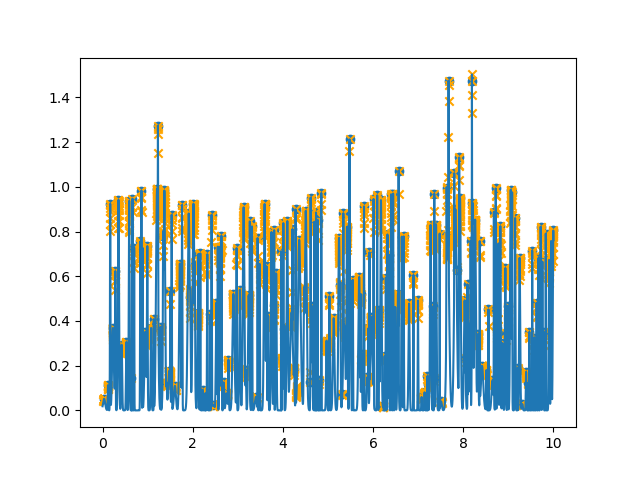

In [7]:
plt.figure()
i=np.random.randint(0,2000)

print(binary_peaks.shape)

all_ones = np.where(binary_peaks[i] > 0)[0]
all_ones.shape

plt.plot(x, signals[i])
plt.scatter(x[all_peaks[i]], signals[i][all_peaks[i]])

plt.scatter(x[all_ones], signals[i][all_ones], marker='x', color='orange')

plt.show()


In [8]:
def add_noise_by_percentage(signal, noise_percentage):
        """
        Add random noise to a NumPy array based on a percentage of the maximum signal value.

        Parameters:
            signal (numpy.ndarray): The original signal array.
            noise_percentage (float): Percentage of the maximum signal value to use as noise.

        Returns:
            noisy_signal (numpy.ndarray): The signal array with added noise.
        """
        # Find the maximum value in the signal
        max_value = np.max(np.abs(signal))

        # Calculate the noise standard deviation as a percentage of the max signal value
        noise_std = (noise_percentage / 100) * max_value

        # Generate random Gaussian noise with zero mean and calculated standard deviation
        noise = np.random.normal(0.005, noise_std, signal.shape)

        # Add the noise to the original signal
        noisy_signal = signal + noise

        return noisy_signal

noisy_level = 0.2
noisy_signal = add_noise_by_percentage(signals, noisy_level)

In [9]:
ds = xr.Dataset(
    {
        "Intensities": (["pattern", "x"], noisy_signal),
        "BinaryArr": (["pattern", "x"], binary_peaks)
    },
    coords = {
        "pattern": np.arange(num_repetitions),
        "x": np.linspace(1, 10, x.shape[0])
    },
    attrs={
        "description": "Simulated asymmetric split gaussian signals with labeled peaks, padded with 1s along mean +- FWHM/4",
        "min_d_rule": "Minimum distance between peaks = 2 * fwhm",
        "note": f"Each pattern contains a {peak_density} number of peaks peaks. Used_means enforces peak spacing.",
        "params": 
        "A_values = np.random.uniform(0.01, 1.0), mu_values = np.random.uniform(0,10), min_w = 0.001, max_w = 0.03, width = np.random.uniform(min_w, max_w), sigma_l_values = np.random.uniform(width*0.9, width*1.1), sigma_r_values = np.random.uniform(width*0.9, width*1.1)",
        "noise": f"True, {noisy_level}%"
    }
)


(2000, 11837)


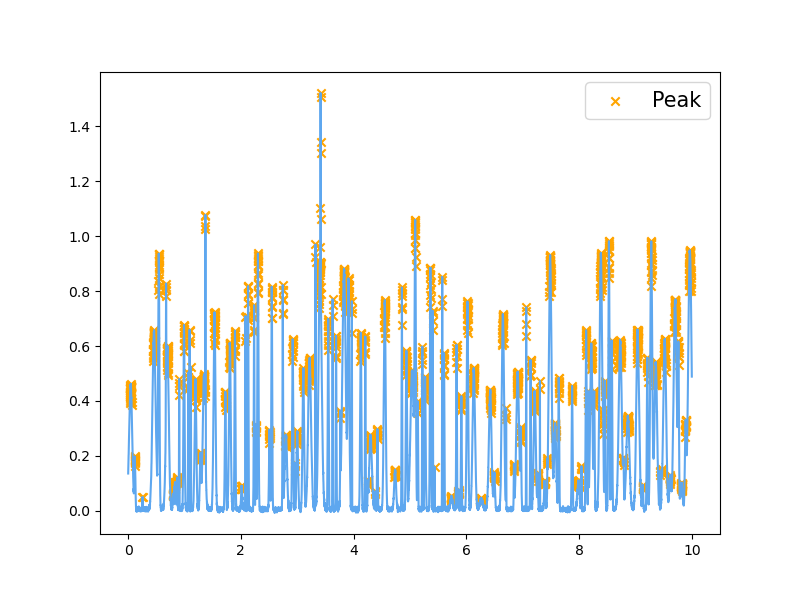

In [26]:
gaussians = ds["Intensities"].values
binary = ds["BinaryArr"].values

# Check that there is noise
plt.figure(figsize=(8,6))

i=np.random.randint(0,2000)
print(binary_peaks.shape)

all_ones = np.where(binary_peaks[i] > 0)[0]
all_ones.shape

plt.plot(x, gaussians[i], color='#5EA7EF')
# plt.scatter(x[all_peaks[i]], gaussians[i][all_peaks[i]])

plt.scatter(x[all_ones], gaussians[i][all_ones], marker='x', color='orange', label='Peak')

plt.legend(fontsize=15)
plt.show()


In [27]:
path = '../saved_data/'
file = f'asymmetric_functions_{peak_density}_noisy.nc'

ds.to_netcdf(os.path.join(path, file))
with ZipFile(os.path.join(path,file.replace('.nc','.zip')), 'w', ZIP_DEFLATED) as zObject:
    zObject.write(os.path.join(path,file), arcname=file)
